In [14]:
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install shap
!pip install kneed




[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


[DATA SHAPES] Raw data shape: (693, 1705)
Sample Type column preview:
0         Tumor Primary
1      First Recurrence
2         Tumor Primary
3      First Recurrence
4         Tumor Primary
             ...       
688    First Recurrence
689       Tumor Primary
690    First Recurrence
691       Tumor Primary
692    First Recurrence
Name: Sample Type, Length: 693, dtype: object
[DATA SHAPES] After dropping missing Sample Type: (693, 1705)
[DATA SHAPES] After cleanup: (692, 1704)
Sample Type Simplified
First Recurrence    318
Tumor Primary       309
n Recurrence         65
Name: count, dtype: int64
Label mapping: {'First Recurrence': 0, 'Tumor Primary': 1, 'n Recurrence': 2}


/tmp/ipykernel_4020/2561994114.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_genes = clinical_data[gene_cols].applymap(lambda x: 0 if str(x).strip().upper() == "WT" else 1)


[DATA SHAPES] Feature matrix: (692, 1706)
[DATA SHAPES] Training set: (553, 1706) Labels: (553,)
[DATA SHAPES] Test set: (139, 1706) Labels: (139,)


/home/celine/PycharmProjects/pythonProject2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/celine/PycharmProjects/pythonProject2/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/celine/PycharmProjects/pythonProject2/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/celine/PycharmProj

                 Model  Accuracy  Precision    Recall  F1 Score
3    Gradient Boosting  0.446043   0.411754  0.446043  0.424042
2                  SVM  0.489209   0.447519  0.489209  0.401857
6        Decision Tree  0.410072   0.400083  0.410072  0.401305
4              XGBoost  0.424460   0.384530  0.424460  0.399405
5                  KNN  0.438849   0.359387  0.438849  0.348459
7          Naive Bayes  0.467626   0.707365  0.467626  0.335101
0        Random Forest  0.345324   0.312255  0.345324  0.327466
1  Logistic Regression  0.294964   0.297266  0.294964  0.295758


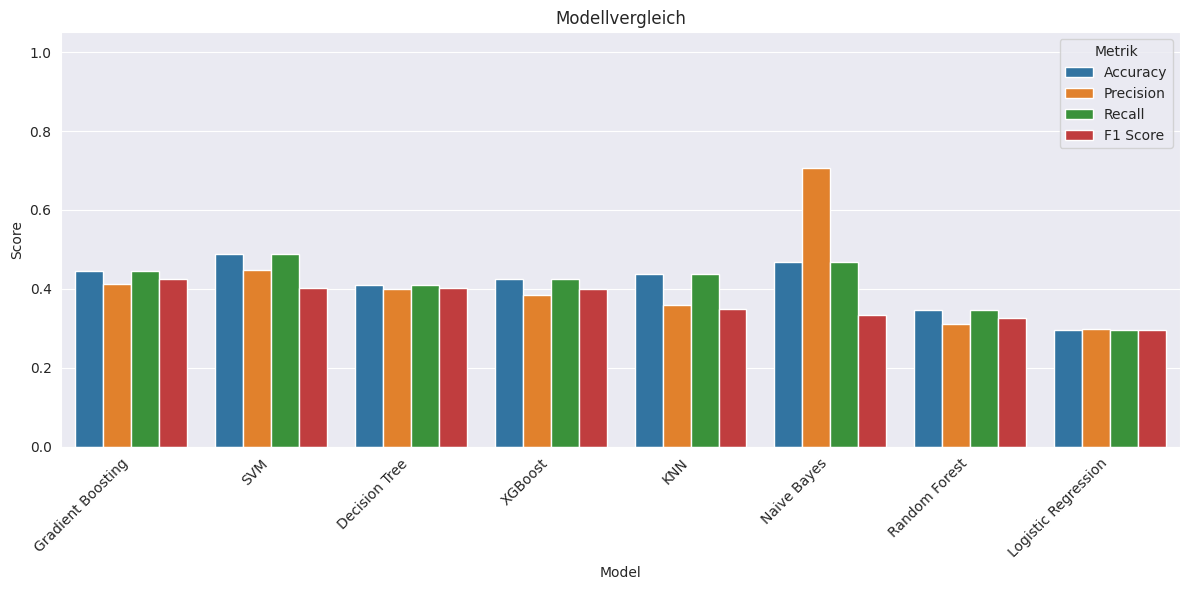

Random Forest Ergebnisse
Accuracy: 0.331

Confusion Matrix:
 [[17 40  7]
 [32 26  4]
 [ 5  5  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.27      0.29        64
           1       0.37      0.42      0.39        62
           2       0.21      0.23      0.22        13

    accuracy                           0.33       139
   macro avg       0.30      0.31      0.30       139
weighted avg       0.33      0.33      0.33       139



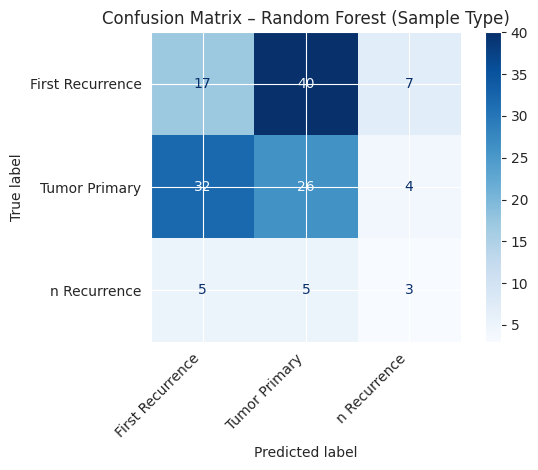

Logistic Regression Ergebnisse
Accuracy: 0.295

Confusion Matrix:
 [[18 38  8]
 [37 20  5]
 [ 5  5  3]]

Classification Report:
                   precision    recall  f1-score   support

First Recurrence       0.30      0.28      0.29        64
   Tumor Primary       0.32      0.32      0.32        62
    n Recurrence       0.19      0.23      0.21        13

        accuracy                           0.29       139
       macro avg       0.27      0.28      0.27       139
    weighted avg       0.30      0.29      0.30       139



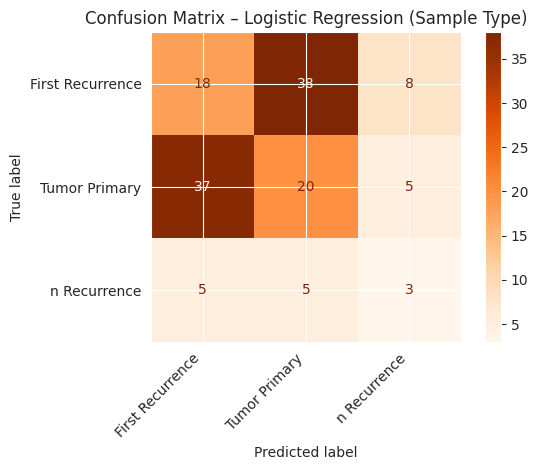

Decision Tree Ergebnisse
Accuracy: 0.41

Confusion Matrix:
 [[31 28  5]
 [37 25  0]
 [ 9  3  1]]

Classification Report:
                   precision    recall  f1-score   support

First Recurrence       0.40      0.48      0.44        64
   Tumor Primary       0.45      0.40      0.42        62
    n Recurrence       0.17      0.08      0.11        13

        accuracy                           0.41       139
       macro avg       0.34      0.32      0.32       139
    weighted avg       0.40      0.41      0.40       139



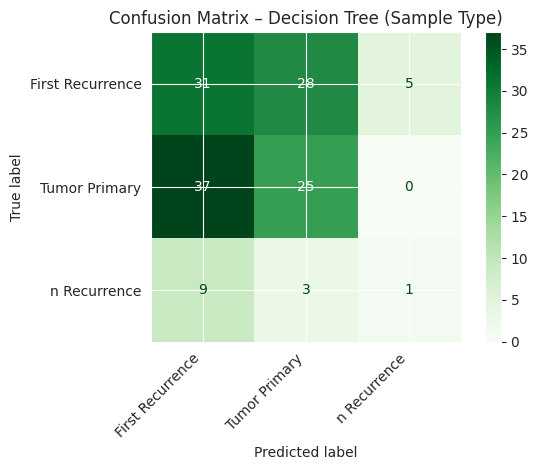

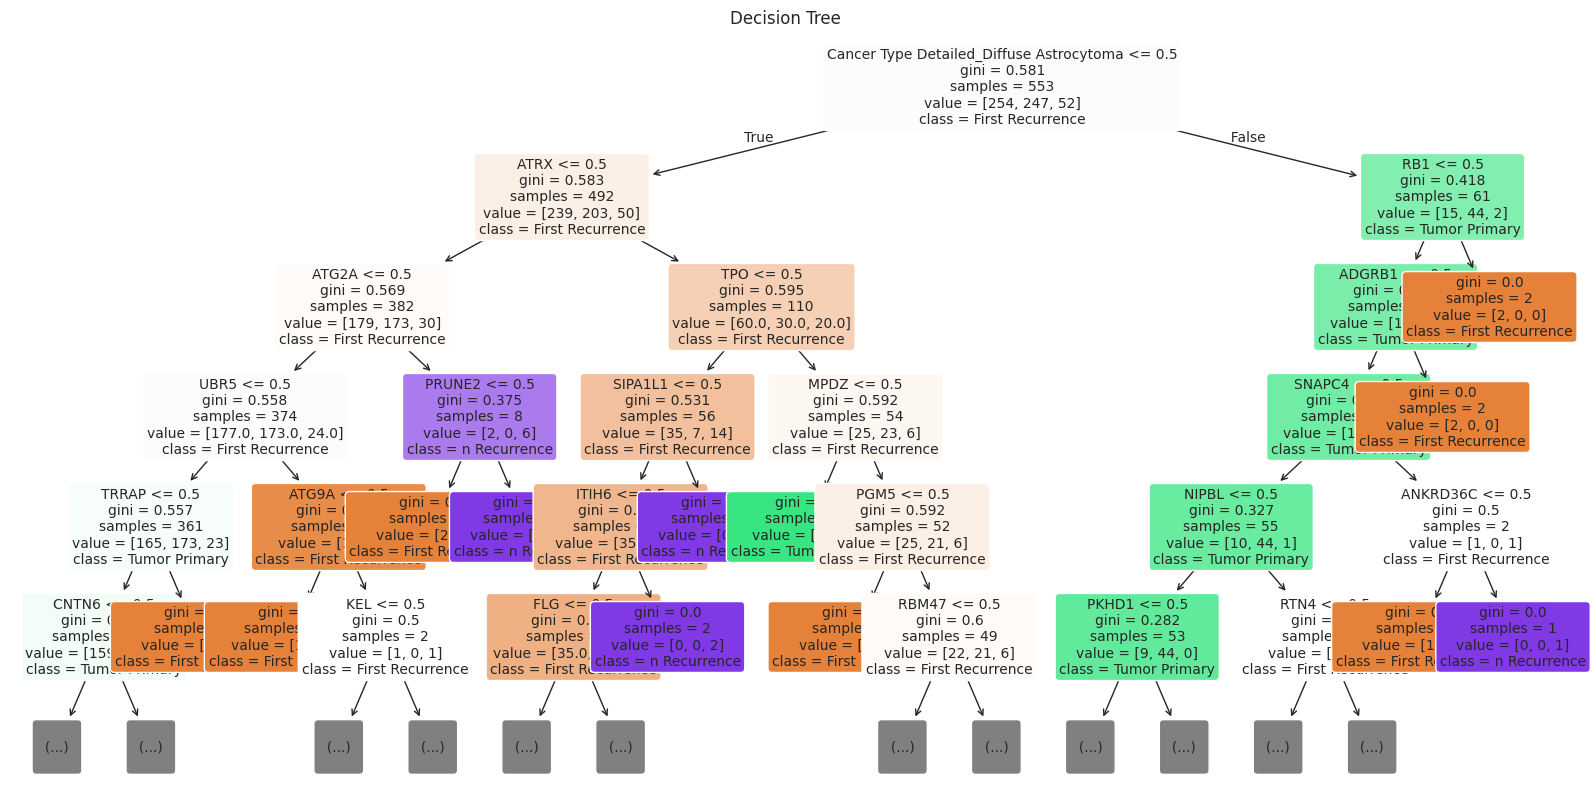

/tmp/ipykernel_4020/2561994114.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='coolwarm')


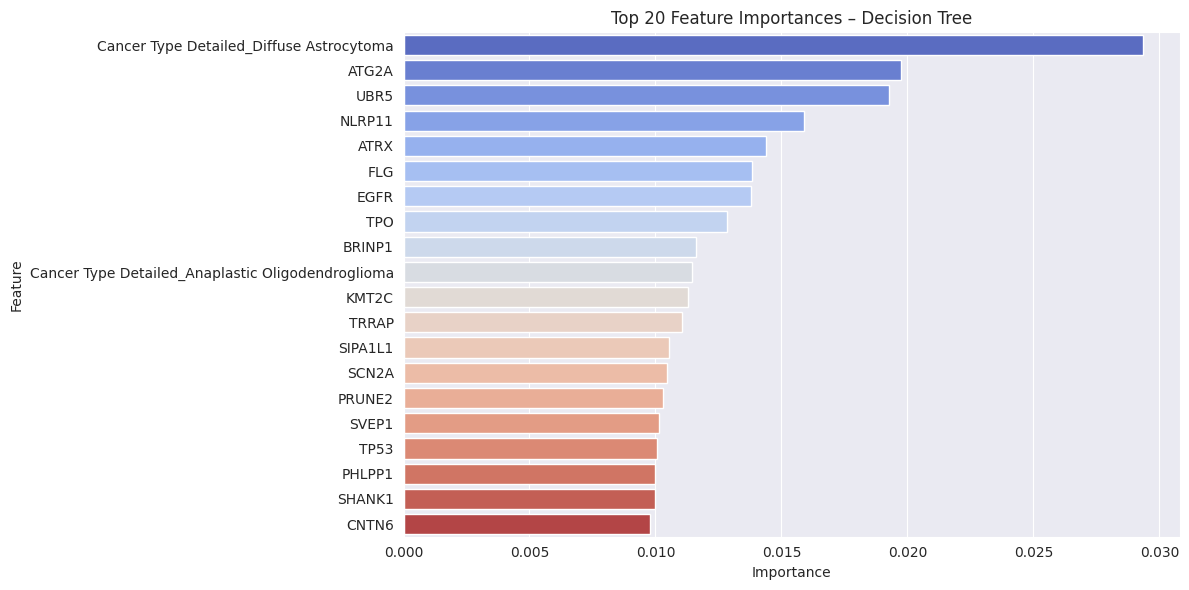

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import plot_tree

############### Data Loading ###############
clinical_data = pd.read_csv("hcai_data-main/combined_data.tsv.txt", sep="\t")
print("[DATA SHAPES] Raw data shape:", clinical_data.shape)

print("Sample Type column preview:")
print(clinical_data["Sample Type"])

# Drop rows with missing Sample Type
clinical_data = clinical_data.dropna(subset=["Sample Type"])
print("[DATA SHAPES] After dropping missing Sample Type:", clinical_data.shape)

# Drop survival columns
clinical_data = clinical_data.drop("Overall Survival", axis='columns')
clinical_data = clinical_data.drop("Overall Survival (months)", axis='columns')

############### Simplify Sample Types ###############
def simplify_sample_type(sample):
    sample = sample.strip().lower()
    if "second recurrence" in sample or "third recurrence" in sample or "fourth recurrence" in sample:
        return "n Recurrence"
    elif "first recurrence" in sample:
        return "First Recurrence"
    elif "tumor primary" in sample:
        return "Tumor Primary"
    elif "first metastasis" in sample:
        return "REMOVE"
    else:
        return np.nan

clinical_data["Sample Type Simplified"] = clinical_data["Sample Type"].apply(simplify_sample_type)

# Remove NaN and "REMOVE"
clinical_data = clinical_data[clinical_data["Sample Type Simplified"].notna()]
clinical_data = clinical_data[clinical_data["Sample Type Simplified"] != "REMOVE"]

print("[DATA SHAPES] After cleanup:", clinical_data.shape)
print(clinical_data["Sample Type Simplified"].value_counts())

############### Encoding Labels ###############
y = clinical_data["Sample Type Simplified"]
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
print("Label mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

############### Feature Selection ###############
non_gene_cols = [
    "STUDY_ID", "STUDY_ID_x", "SAMPLE_ID", "Cancer Type Detailed",
    "Overall Survival", "Overall Survival (months)",
    "Sample Type", "Sample Type Simplified"
]

gene_cols = [col for col in clinical_data.columns if col not in non_gene_cols]
X_genes = clinical_data[gene_cols].applymap(lambda x: 0 if str(x).strip().upper() == "WT" else 1)

X_clinical = pd.get_dummies(clinical_data[["Cancer Type Detailed"]], drop_first=True)

# Combine features
X = pd.concat([X_genes, X_clinical], axis=1)
print("[DATA SHAPES] Feature matrix:", X.shape)

############### Train-Test Split ###############
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

print("[DATA SHAPES] Training set:", X_train.shape, "Labels:", y_train.shape)
print("[DATA SHAPES] Test set:", X_test.shape, "Labels:", y_test.shape)



############### Models ###############
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(results_df)

plt.figure(figsize=(12,6))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Modellvergleich")
plt.ylim(0,1.05)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Metrik")
plt.show()

######################################################################

############### Random Forest ###############
model = RandomForestClassifier(class_weight="balanced",random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Random Forest Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


labels = unique_labels(y_test, y_pred)
class_names = encoder.inverse_transform(labels)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=class_names,
    cmap='Blues'
)
plt.title("Confusion Matrix – Random Forest (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
#print("\nClassification Report:\n", classification_report(y_test, y_pred_log, target_names=encoder.classes_))


labels_log = unique_labels(y_test, y_pred_log)
class_names_log = encoder.inverse_transform(labels_log)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_log,
                            labels=labels_log,
                            target_names=class_names_log))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=class_names_log,
    cmap='Oranges'
)
plt.title("Confusion Matrix – Logistic Regression (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

############### Decision Tree ###############
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred_tree), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

labels_tree = unique_labels(y_test, y_pred_tree)
class_names_tree = encoder.inverse_transform(labels_tree)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_tree,
                            labels=labels_tree,
                            target_names=class_names_tree))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_tree,
    display_labels=class_names_tree,
    cmap='Greens'
)
plt.title("Confusion Matrix – Decision Tree (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,10))
plot_tree(tree_model, 
          feature_names=X.columns, 
          class_names=encoder.classes_,
          filled=True, 
          rounded=True,  
          fontsize=10,
          max_depth=5)
plt.title("Decision Tree")
plt.show()

############### Feature Importance ###############
importances = tree_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='coolwarm')
plt.title("Top 20 Feature Importances – Decision Tree")
plt.tight_layout()
plt.show()


 Decision Tree Accuracy (Mutationsdaten): 0.381294964028777
shap_values_g.shape = (139, 1699, 3)
X_test_g.shape = (139, 1699)


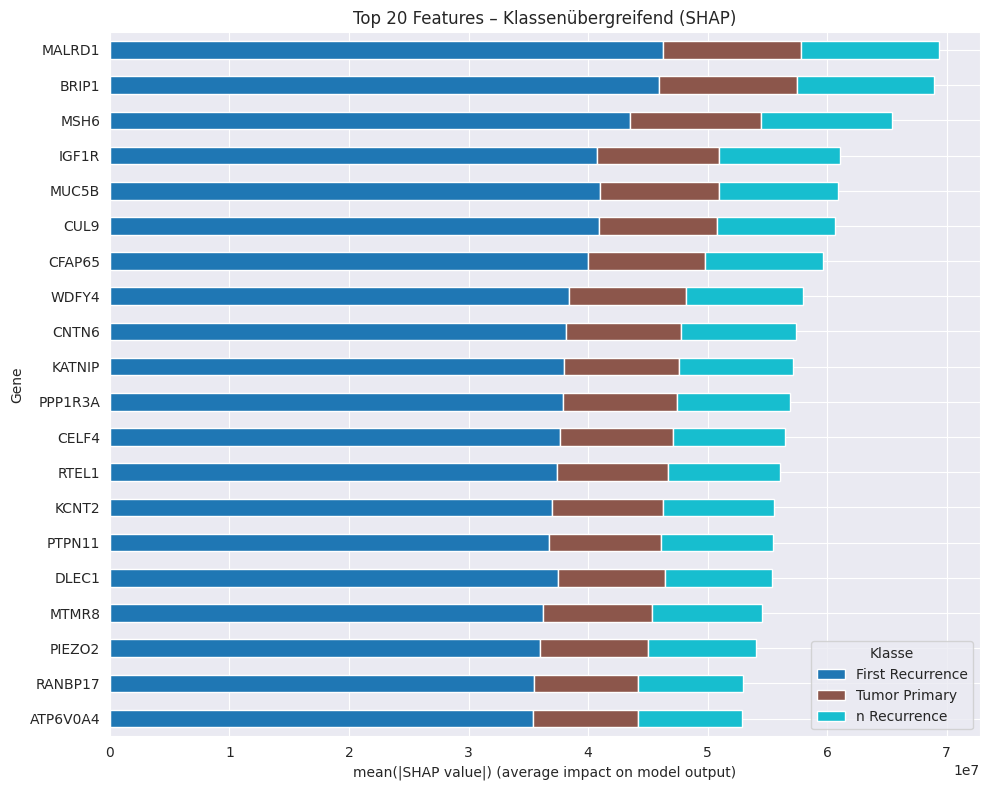

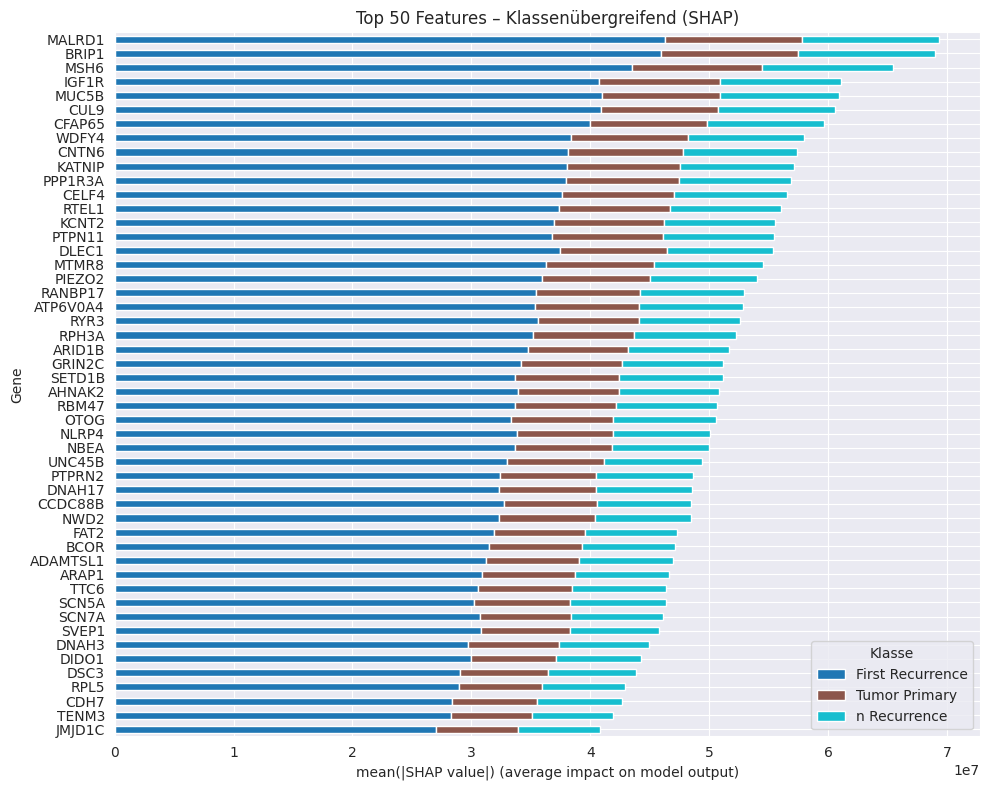

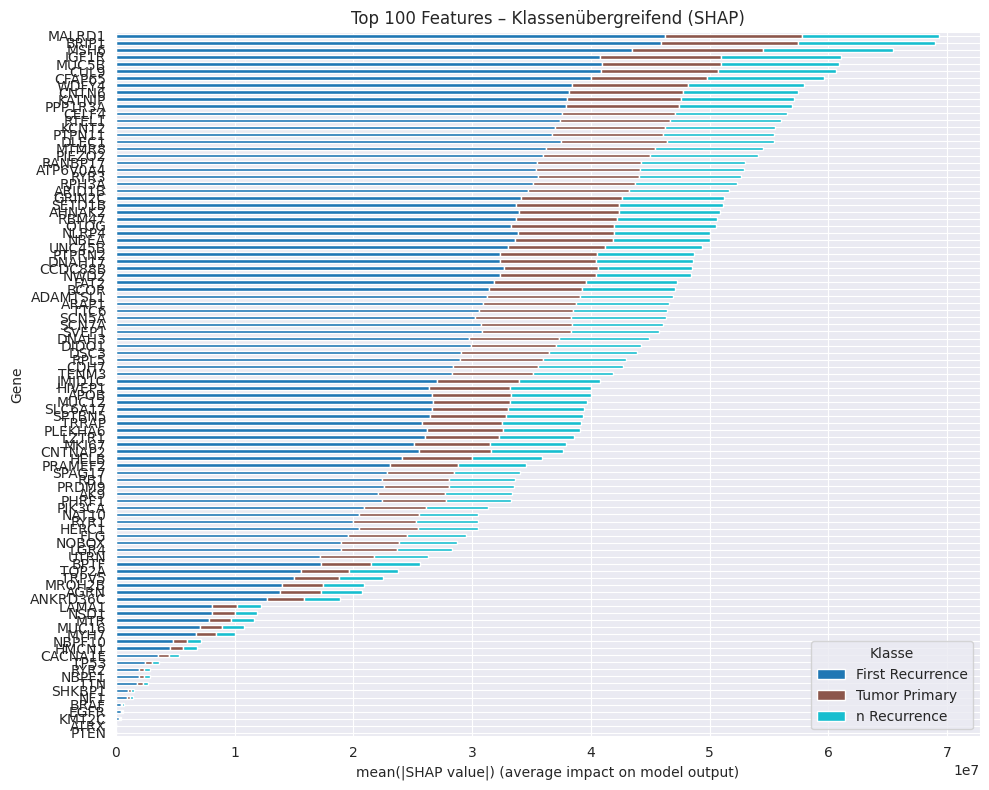

In [16]:
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

combined_data = pd.read_csv("hcai_data-main/combined_data.tsv.txt", sep="\t")

combined_data["Sample Type Simplified"] = combined_data["Sample Type"].apply(simplify_sample_type)

combined_data = combined_data[combined_data["Sample Type Simplified"].notna()]
combined_data = combined_data[combined_data["Sample Type Simplified"] != "REMOVE"]

y_genes = combined_data["Sample Type Simplified"]
encoder_genes = LabelEncoder()
y_genes_enc = encoder_genes.fit_transform(y_genes)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_genes, y_genes_enc, stratify=y_genes_enc, test_size=0.2, random_state=42
)

############### Train Decision Tree ###############
tree_model_g = DecisionTreeClassifier(max_depth=None, random_state=42)
tree_model_g.fit(X_train_g, y_train_g)

print(" Decision Tree Accuracy (Mutationsdaten):", tree_model_g.score(X_test_g, y_test_g))

############### SHAP ###############
explainer_g = shap.TreeExplainer(tree_model_g)

shap_values_g = explainer_g.shap_values(X_test_g,check_additivity=False)

print("shap_values_g.shape =", np.array(shap_values_g).shape)
print("X_test_g.shape =", X_test_g.shape)

## Mittelwert über alle Samples pro Klasse
shap_class_array = np.abs(shap_values_g).mean(axis=0)  # shape: (n_features, n_classes)

# DataFrame bauen
shap_class_df = pd.DataFrame(
    shap_class_array,
    index=X_test_g.columns,          # Gene als Zeilen
    columns=encoder_genes.classes_   # Klassen als Spalten
)

# Total berechnen (klassenübergreifend)
shap_class_df["Total"] = shap_class_df.sum(axis=1)

# Top 20,50,100 Gene
top_20_features = shap_class_df.sort_values("Total", ascending=False).head(20)
top_50_features = shap_class_df.sort_values("Total", ascending=False).head(50)
top_100_features = shap_class_df.sort_values("Total", ascending=False).head(100)


top_20_features = top_20_features.drop(columns="Total")
top_50_features = top_50_features.drop(columns="Total")
top_100_features = top_100_features.drop(columns="Total")


# Plotten
top_20_features.plot(kind="barh", stacked=True, figsize=(10, 8), colormap="tab10")
plt.xlabel("mean(|SHAP value|) (average impact on model output)")
plt.ylabel("Gene")
plt.title("Top 20 Features – Klassenübergreifend (SHAP)")
plt.legend(title="Klasse")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


top_50_features.plot(kind="barh", stacked=True, figsize=(10, 8), colormap="tab10")
plt.xlabel("mean(|SHAP value|) (average impact on model output)")
plt.ylabel("Gene")
plt.title("Top 50 Features – Klassenübergreifend (SHAP)")
plt.legend(title="Klasse")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top_100_features.plot(kind="barh", stacked=True, figsize=(10, 8), colormap="tab10")
plt.xlabel("mean(|SHAP value|) (average impact on model output)")
plt.ylabel("Gene")
plt.title("Top 100 Features – Klassenübergreifend (SHAP)")
plt.legend(title="Klasse")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


 Klasse: First Recurrence


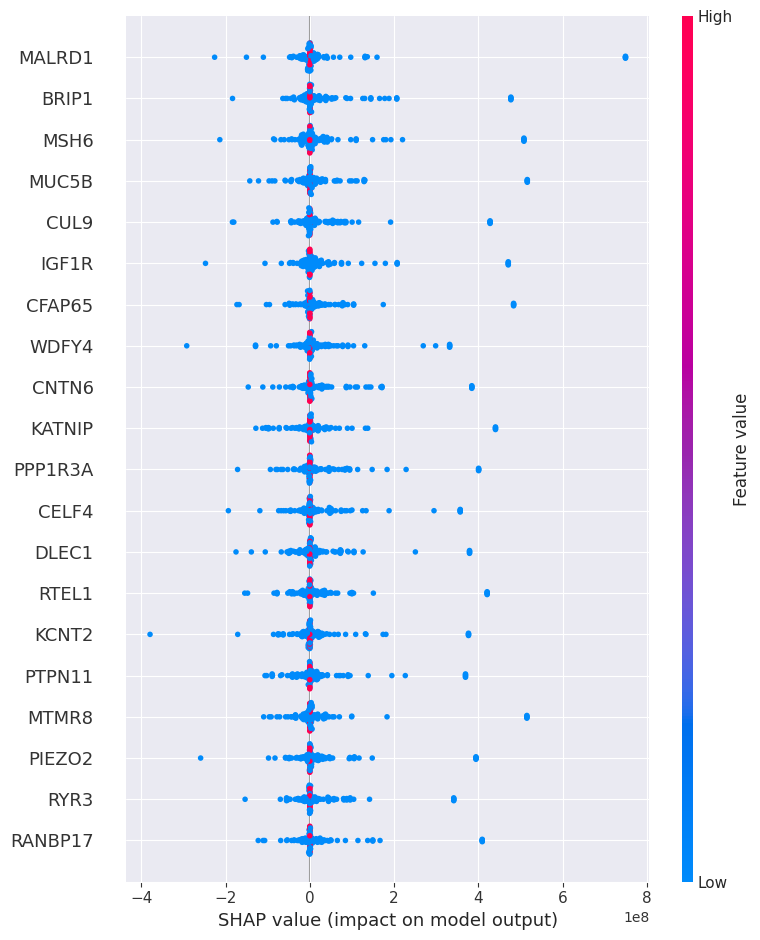


 Klasse: Tumor Primary


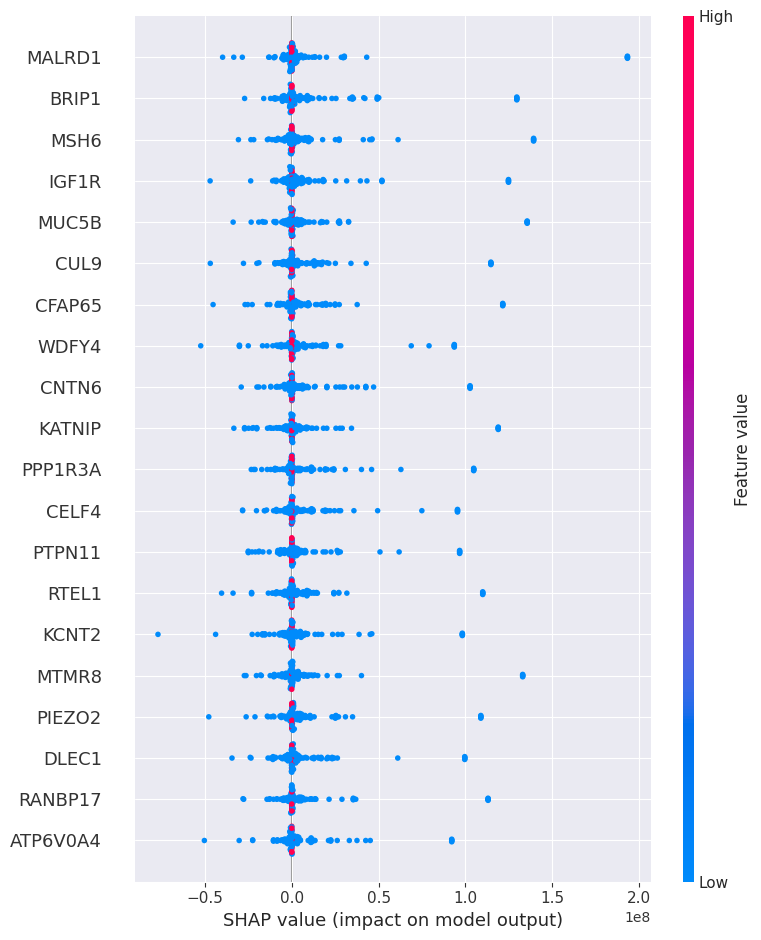


 Klasse: n Recurrence


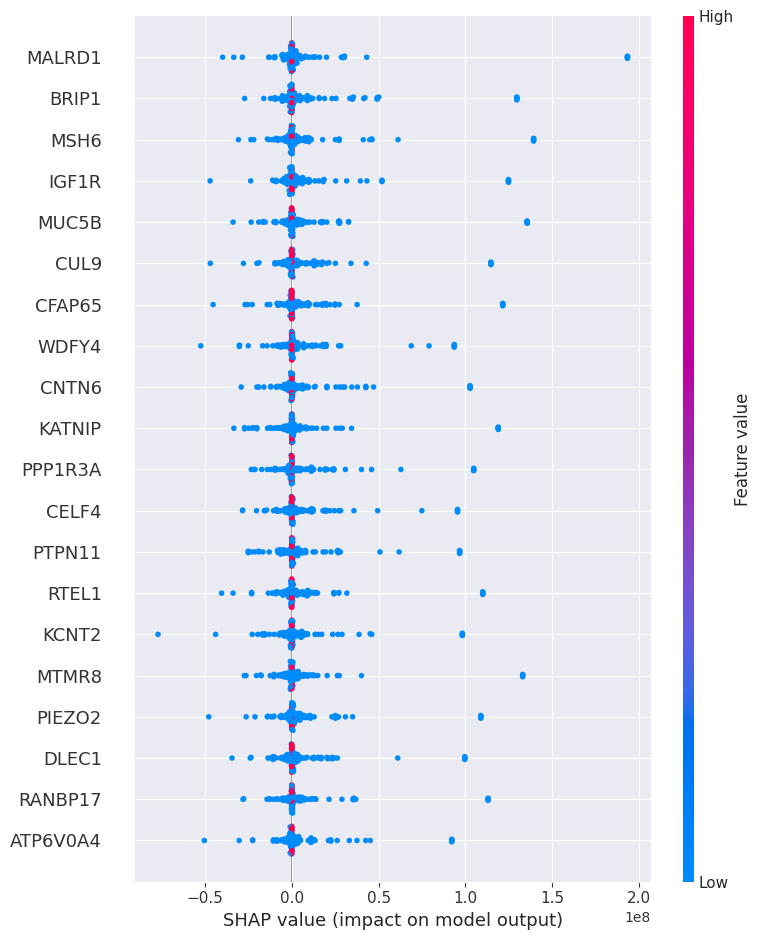

In [17]:
# Summary Plot (jede Klasse )
n_classes = len(shap_values_g)#shap_values_g.shape[2]

for i, class_name in enumerate(encoder_genes.classes_):
    sv = shap_values_g[:, :, i]   # slicen
    print(f"\n Klasse: {class_name}")

    assert sv.shape == X_test_g.shape, f"Shape mismatch: sv={sv.shape} vs X_test_g={X_test_g.shape}"

    shap.summary_plot(
        sv,
        X_test_g,
        plot_type="dot",
        max_display=20,
        show=True
    )

In [18]:
# Top 20 gene extrahiern
top_20_gene_names = top_20_features.index.tolist()
print("Top 20: ", top_20_gene_names)

X_genes_top20 = X_genes[top_20_gene_names]

X_train_top20, X_test_top20, y_train_top20, y_test_top20 = train_test_split(
    X_genes_top20, y_genes_enc, stratify=y_genes_enc, test_size=0.2, random_state=42
)

tree_model_top20 = DecisionTreeClassifier(random_state=42)
tree_model_top20.fit(X_train_top20, y_train_top20)

#from sklearn.metrics import classification_report, confusion_matrix
y_pred_top20 = tree_model_top20.predict(X_test_top20)

print("\nErgebnisse mit Top-20 Features:\n")
print(classification_report(y_test_top20, y_pred_top20, target_names=encoder_genes.classes_))

# Confusion Matrix anzeigen
cm_20 = confusion_matrix(y_test_top20, y_pred_top20)
print("Confusion Matrix:\n", cm_20)


acc_full = tree_model_g.score(X_test_g, y_test_g)
acc_top20 = tree_model_top20.score(X_test_top20, y_test_top20)

print(f"🔍 Accuracy Vergleich:\n - Full Feature Set:  {acc_full:.3f}\n - Top-20 Features:  {acc_top20:.3f}")

Top 20:  ['MALRD1', 'BRIP1', 'MSH6', 'IGF1R', 'MUC5B', 'CUL9', 'CFAP65', 'WDFY4', 'CNTN6', 'KATNIP', 'PPP1R3A', 'CELF4', 'RTEL1', 'KCNT2', 'PTPN11', 'DLEC1', 'MTMR8', 'PIEZO2', 'RANBP17', 'ATP6V0A4']

Ergebnisse mit Top-20 Features:

                  precision    recall  f1-score   support

First Recurrence       0.42      0.16      0.23        64
   Tumor Primary       0.47      0.87      0.61        62
    n Recurrence       0.00      0.00      0.00        13

        accuracy                           0.46       139
       macro avg       0.30      0.34      0.28       139
    weighted avg       0.40      0.46      0.38       139

Confusion Matrix:
 [[10 53  1]
 [ 8 54  0]
 [ 6  7  0]]
🔍 Accuracy Vergleich:
 - Full Feature Set:  0.381
 - Top-20 Features:  0.460


In [19]:
# Top 50 gene extrahiern
top_50_gene_names = top_50_features.index.tolist()
print("Top 50: ", top_50_gene_names)


X_genes_top50 = X_genes[top_50_gene_names]

X_train_top50, X_test_top50, y_train_top50, y_test_top50 = train_test_split(
    X_genes_top50, y_genes_enc, stratify=y_genes_enc, test_size=0.2, random_state=42
)

tree_model_top50 = DecisionTreeClassifier(random_state=42)
tree_model_top50.fit(X_train_top50, y_train_top50)

y_pred_top50 = tree_model_top50.predict(X_test_top50)

print("\nErgebnisse mit Top-50 Features:\n")
print(classification_report(y_test_top50, y_pred_top50, target_names=encoder_genes.classes_))

############### Confusion Matrix ###############
cm_50 = confusion_matrix(y_test_top50, y_pred_top50)
print("Confusion Matrix:\n", cm_50)


acc_full = tree_model_g.score(X_test_g, y_test_g)
acc_top50 = tree_model_top50.score(X_test_top50, y_test_top50)

print(f"🔍 Accuracy Vergleich:\n - Full Feature Set:  {acc_full:.3f}\n - Top-50 Features:  {acc_top50:.3f}")

#recall first reccurrence bricht auch hier stark ein, tumor primary besser

Top 50:  ['MALRD1', 'BRIP1', 'MSH6', 'IGF1R', 'MUC5B', 'CUL9', 'CFAP65', 'WDFY4', 'CNTN6', 'KATNIP', 'PPP1R3A', 'CELF4', 'RTEL1', 'KCNT2', 'PTPN11', 'DLEC1', 'MTMR8', 'PIEZO2', 'RANBP17', 'ATP6V0A4', 'RYR3', 'RPH3A', 'ARID1B', 'GRIN2C', 'SETD1B', 'AHNAK2', 'RBM47', 'OTOG', 'NLRP4', 'NBEA', 'UNC45B', 'PTPRN2', 'DNAH17', 'CCDC88B', 'NWD2', 'FAT2', 'BCOR', 'ADAMTSL1', 'ARAP1', 'TTC6', 'SCN5A', 'SCN7A', 'SVEP1', 'DNAH3', 'DIDO1', 'DSC3', 'RPL5', 'CDH7', 'TENM3', 'JMJD1C']

Ergebnisse mit Top-50 Features:

                  precision    recall  f1-score   support

First Recurrence       0.41      0.23      0.30        64
   Tumor Primary       0.45      0.71      0.55        62
    n Recurrence       0.20      0.08      0.11        13

        accuracy                           0.43       139
       macro avg       0.35      0.34      0.32       139
    weighted avg       0.41      0.43      0.39       139

Confusion Matrix:
 [[15 46  3]
 [17 44  1]
 [ 5  7  1]]
🔍 Accuracy Vergleich:
 - Ful

In [20]:
# Top 100 gene extrahiern
top_100_gene_names = top_100_features.index.tolist()
print("Top 100: ", top_100_gene_names)


X_genes_top100 = X_genes[top_100_gene_names]

X_train_top100, X_test_top100, y_train_top100, y_test_top100 = train_test_split(
    X_genes_top100, y_genes_enc, stratify=y_genes_enc, test_size=0.2, random_state=42
)

tree_model_top100 = DecisionTreeClassifier(random_state=42)
tree_model_top100.fit(X_train_top100, y_train_top100)

y_pred_top100 = tree_model_top100.predict(X_test_top100)

print("\nErgebnisse mit Top-100 Features:\n")
print(classification_report(y_test_top100, y_pred_top100, target_names=encoder_genes.classes_))

# Confusion Matrix 
cm_100 = confusion_matrix(y_test_top100, y_pred_top100)
print("Confusion Matrix:\n", cm_100)


acc_full = tree_model_g.score(X_test_g, y_test_g)
acc_top100 = tree_model_top100.score(X_test_top100, y_test_top100)

print(f"Accuracy Vergleich:\n - Full Feature Set:  {acc_full:.3f}\n - Top-100 Features:  {acc_top100:.3f}")


Top 100:  ['MALRD1', 'BRIP1', 'MSH6', 'IGF1R', 'MUC5B', 'CUL9', 'CFAP65', 'WDFY4', 'CNTN6', 'KATNIP', 'PPP1R3A', 'CELF4', 'RTEL1', 'KCNT2', 'PTPN11', 'DLEC1', 'MTMR8', 'PIEZO2', 'RANBP17', 'ATP6V0A4', 'RYR3', 'RPH3A', 'ARID1B', 'GRIN2C', 'SETD1B', 'AHNAK2', 'RBM47', 'OTOG', 'NLRP4', 'NBEA', 'UNC45B', 'PTPRN2', 'DNAH17', 'CCDC88B', 'NWD2', 'FAT2', 'BCOR', 'ADAMTSL1', 'ARAP1', 'TTC6', 'SCN5A', 'SCN7A', 'SVEP1', 'DNAH3', 'DIDO1', 'DSC3', 'RPL5', 'CDH7', 'TENM3', 'JMJD1C', 'HIVEP1', 'APOB', 'MUC12', 'SLC6A17', 'SPTBN5', 'TRRAP', 'PLEKHA6', 'LZTR1', 'MKI67', 'CNTNAP2', 'HELB', 'PRAMEF2', 'SPAG17', 'RB1', 'PRDM9', 'AK9', 'PHRF1', 'PIK3CA', 'NAT10', 'RYR1', 'HERC1', 'FLG', 'NOBOX', 'LGR4', 'UTRN', 'BPTF', 'TOP2A', 'TRPV5', 'MROH2B', 'AGRN', 'ANKRD36C', 'LAMA1', 'NSD1', 'MTR', 'MUC16', 'MYH7', 'NBPF10', 'HMCN1', 'CACNA1E', 'TP53', 'RYR2', 'NBPF1', 'TTN', 'SHKBP1', 'NF1', 'BRAF', 'EGFR', 'KMT2C', 'ATRX', 'PTEN']

Ergebnisse mit Top-100 Features:

                  precision    recall  f1-score 

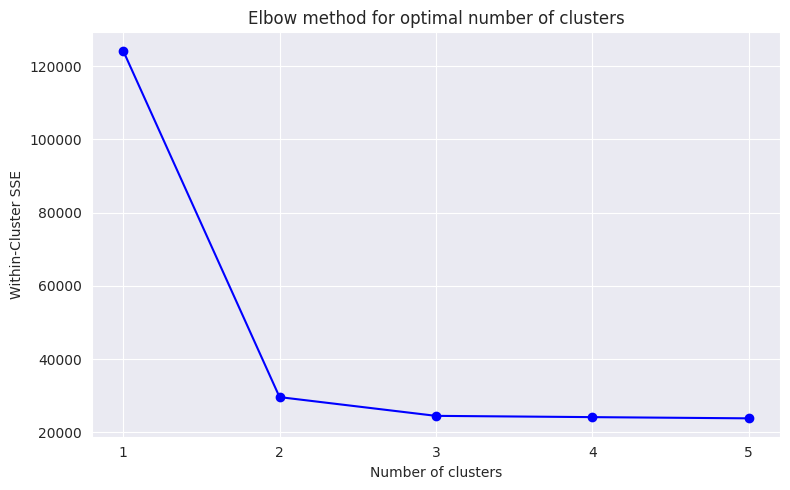

Optimal number of clusters according to elbow method: 2



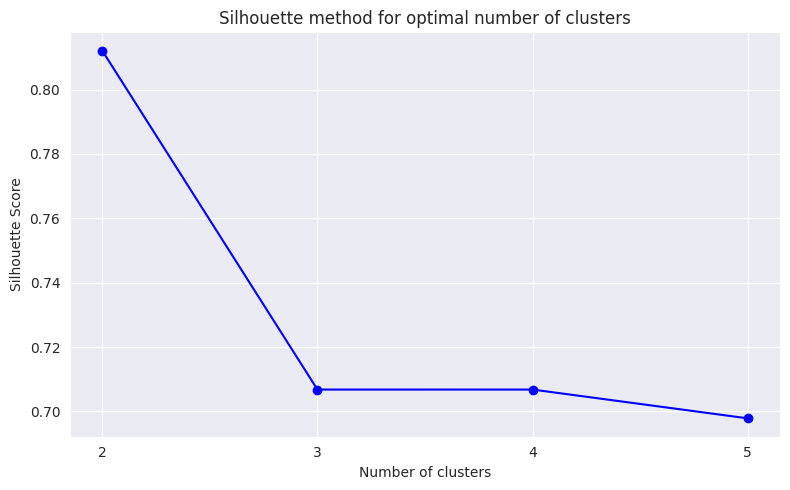

Optimal number of clusters according to silhouette method: 2


NameError: name 'df' is not defined

In [21]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from kneed import KneeLocator



############### Elbow method to find optimal number of clusters ###############
sse = [] #ssum of squared errors
K = range(1, 6) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster SSE')
plt.title('Elbow method for optimal number of clusters')
plt.xticks(K)
plt.grid(True)
plt.tight_layout()
plt.show()

#kneelocator to print out optimal number of clusters
knee = KneeLocator(K, sse, curve='convex', direction='decreasing')
print(f"Optimal number of clusters according to elbow method: {knee.knee}\n")

#------Silhouette method to evaluate cluster quality----#

silhouette_scores = []
K_sil = range(2, 6) 

for k in K_sil:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_sil, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette method for optimal number of clusters')
plt.xticks(K_sil)
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = K_sil[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters according to silhouette method: {best_k}")

############### K-Means ###############
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

X["Cluster"] = clusters

# labels nicht encoded
#df_analysis = df_encoded.copy()
df_analysis = X_clinical.copy()
df_analysis["Cluster"] = clusters
df_analysis["Sample Type"] = df["Sample Type Simplified"].values 
#df_analysis["Sample Type"] = 

############### comparison Cluster vs. Sample Type ###############
#crosstab computes a simple cross tabulation of two (or more) factors
column_order = ["Tumor Primary", "First Recurrence", "n Recurrence"]
crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Sample Type Simplified"], normalize='index')[column_order]
print("Cluster vs. RSample Type Simplified\n")
print("Rounded crosstab value", crosstab.round(2))
crosstab.plot(kind='bar', stacked=False, colormap='plasma', figsize=(10,6))
plt.title("K-Means Clusters vs. Sample Type Simplified")
plt.ylabel("Percentage of Reduced Sample Type within Cluster")
plt.xlabel("Cluster")
plt.legend(title="Sample Type Simplified", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#number of each Sample Types per cluster 
raw_crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Sample Type Simplified"])[column_order]
print("Number of samples per cluster\n")
print(raw_crosstab)
